## The Data
We will be using a dataset recently published by RIOT games(Parent company who owns league of legends) on https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min


# From https://en.wikipedia.org/wiki/League_of_Legends
"League of Legends is a multiplayer online battle arena (MOBA) game in the three-dimensional isometric perspective. The game consists of two current running game modes: Summoner's Rift and Howling Abyss. The Crystal Scar and Twisted Treeline, maps corresponding to discontinued game modes, have since been removed. Camera perspective cannot be changed by a player, other than zooming and panning, thus whether the player spawns at the top or bottom bases will be fixed for the duration of the game. Players compete in matches, lasting anywhere from 20 to 50 minutes on average. In each game mode, teams work together to achieve a victory condition, typically destroying the core building (called the Nexus) in the enemy team's base after bypassing a line of defensive structures called turrets, or towers.."

## Our Goal
To analyze the given dataset in order to find the features that are most correlated with blueside winning and finding a machine learning model which best predicts the outcome of the game after 10 minutes game time.


In [1]:
# Importing all the necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Model Evaluations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

#clean up to remove duplicates from above
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('high_diamond_ranked_10min.csv')
df.shape

(9879, 40)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [4]:
df.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


In [5]:
# Removing the following to avoid colinearity. 
# Blue gold to Red gold imply gold difference, as well as gold/experience for towers being destroyed is included in gold/experience totals.
# Average level doesnt matter because we have included totalExperience which is essentially the same metric
blue_col = ['blueDeaths','blueEliteMonsters','blueTowersDestroyed','blueAvgLevel','blueGoldDiff','blueExperienceDiff']

In [6]:
red_col = ['redDeaths','redEliteMonsters','redTowersDestroyed','redAvgLevel','redGoldDiff','redExperienceDiff']

In [7]:
# Dropping above blue columns
df.drop(blue_col, axis=1,inplace=True)

In [8]:
# Dropping above red columns
df.drop(red_col, axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTotalGold                 9879 non-null   int64  
 10  blueTotalExperience           9879 non-null   int64  
 11  blueTotalMinionsKilled        9879 non-null   int64  
 12  blueTotalJungleMinionsKilled  9879 non-null   int64  
 13  blu

In [10]:
# Checking for Null Values
df.isna().sum()

gameId                          0
blueWins                        0
blueWardsPlaced                 0
blueWardsDestroyed              0
blueFirstBlood                  0
blueKills                       0
blueAssists                     0
blueDragons                     0
blueHeralds                     0
blueTotalGold                   0
blueTotalExperience             0
blueTotalMinionsKilled          0
blueTotalJungleMinionsKilled    0
blueCSPerMin                    0
blueGoldPerMin                  0
redWardsPlaced                  0
redWardsDestroyed               0
redFirstBlood                   0
redKills                        0
redAssists                      0
redDragons                      0
redHeralds                      0
redTotalGold                    0
redTotalExperience              0
redTotalMinionsKilled           0
redTotalJungleMinionsKilled     0
redCSPerMin                     0
redGoldPerMin                   0
dtype: int64

In [11]:
# Getting a list of only blue columns
blue_cols = [col for col in df.columns if 'blue' in col]
print(blue_cols)

['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueAssists', 'blueDragons', 'blueHeralds', 'blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueCSPerMin', 'blueGoldPerMin']


In [12]:
# Removing columns that will produce a 1 or 0 value from the future pairplot
blue_cols = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueAssists', 'blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldPerMin']

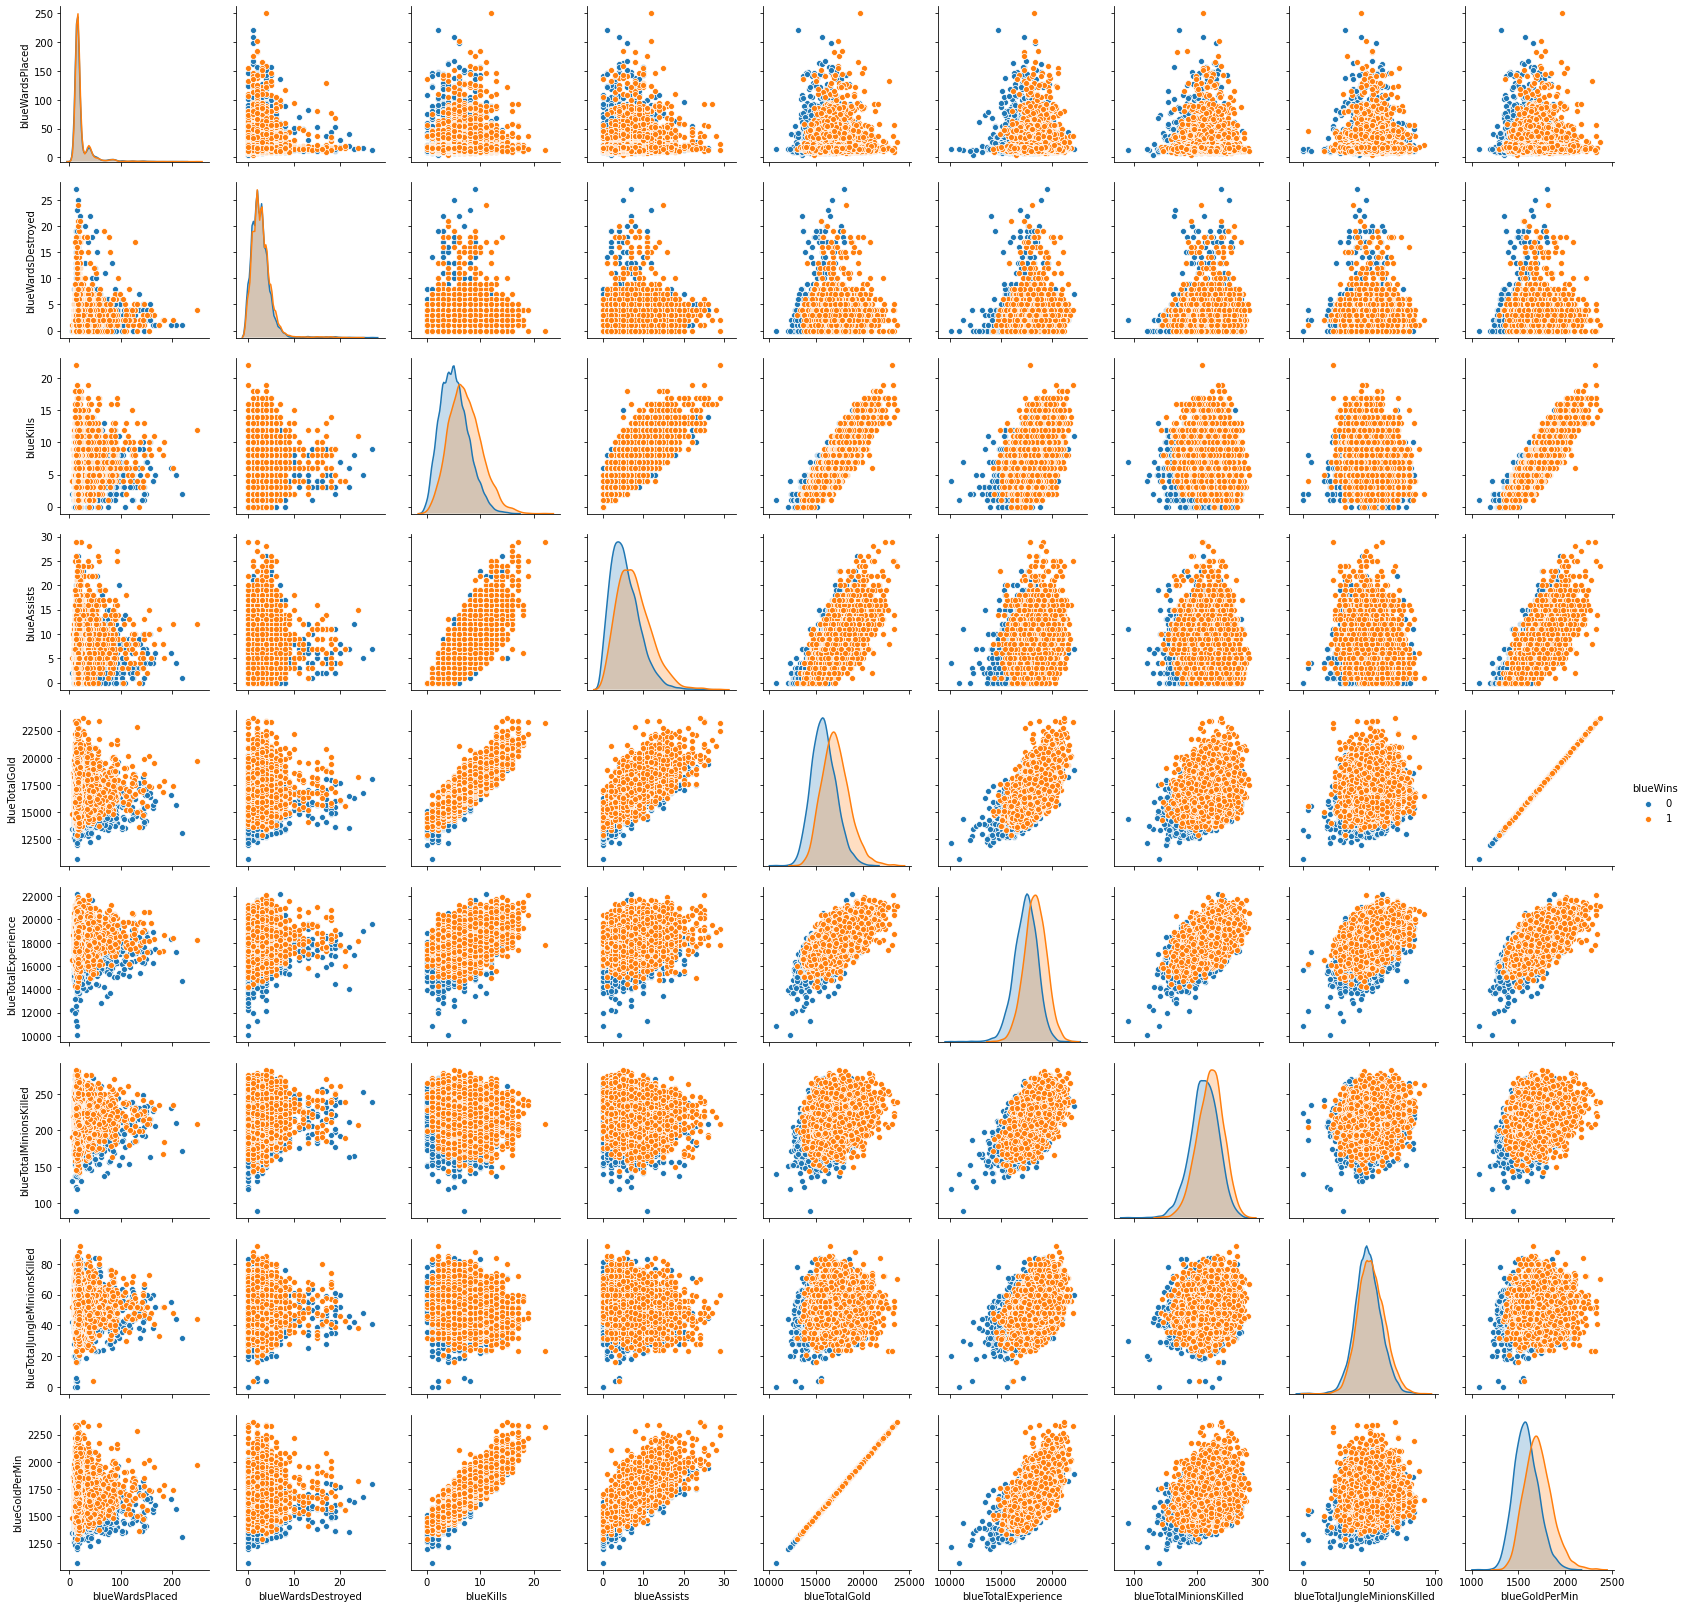

In [13]:
# Following import to hide pairplot warnings
import warnings
warnings.filterwarnings('ignore')

# Use of a pairplot to show relationship of blue team columns/features
sns.pairplot(data=df, vars=blue_cols, hue='blueWins')

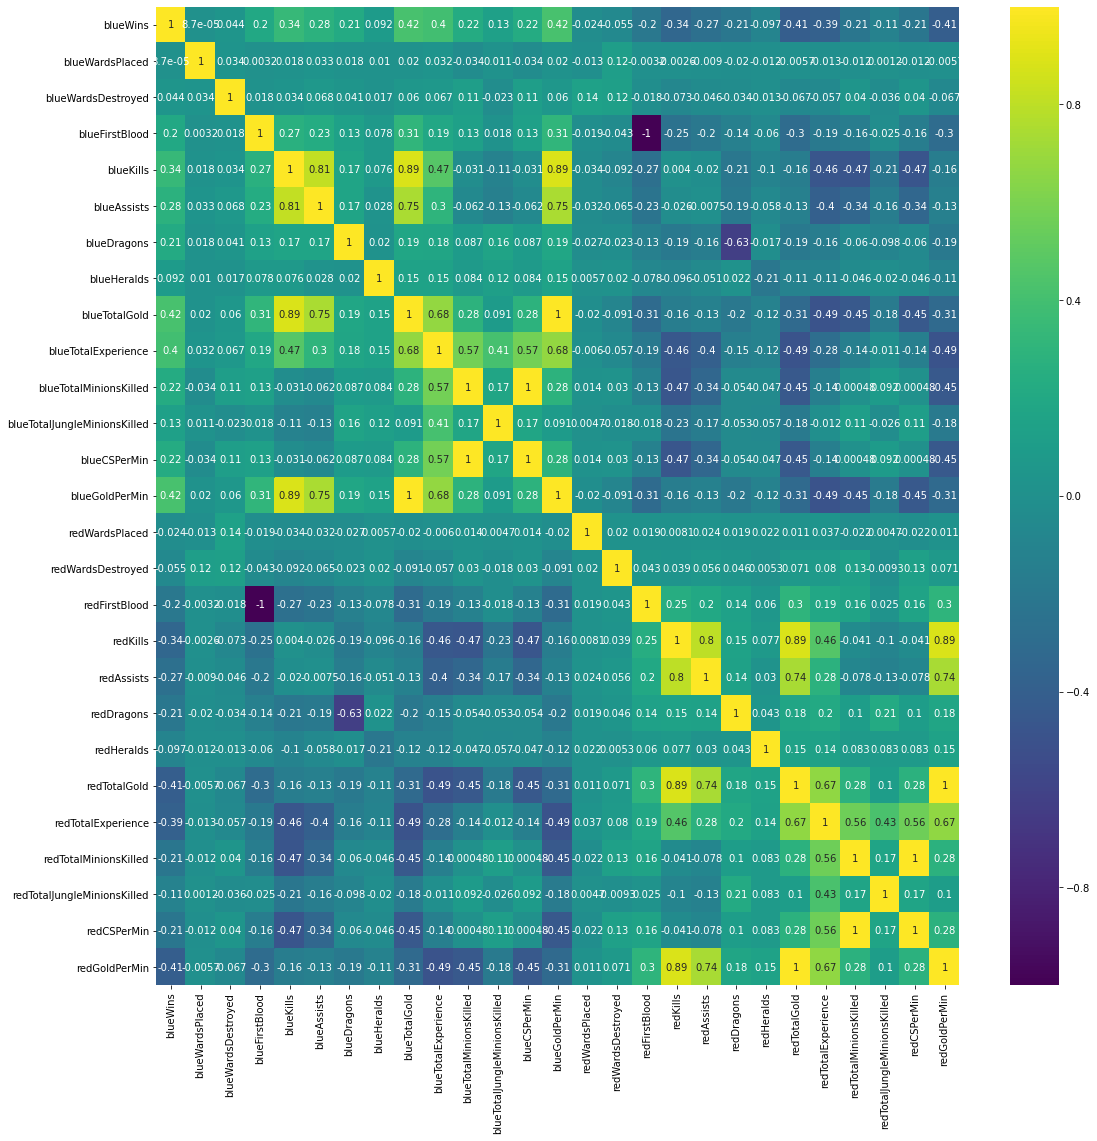

In [14]:
# Now we will look into the correlation of features 
plt.figure(figsize=(18,18))
sns.heatmap(df.drop('gameId', axis=1).corr(),annot=True,cmap='viridis');

# Splitting the data and setting up a Class to work with various Models

In [18]:
# Split data into X and y
X = df.drop("blueWins", axis=1)
y = df['blueWins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of all of the columns
cols = X_train.columns

# Standardize the data
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

print("Train obs: {}; Features Number: {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation obs: {};".format(X_test.shape[0]))

Train obs: 7903; Features Number: 27
Validation obs: 1976;


In [82]:
# Master Learn class which we are going to use for our analysis
class MasterL:
    def __init__(self, model, #### model is a method which we are going to use predicting the outcome.
                 X= X_train, y= y_train, test= X_test, ### data
                 **kvars  #### additional key parameters for model
                ):
        self.clf = model( **kvars)
        self.methodname = model.__name__
        self.X_train = X
        self.y_train = y
        self.X_test = test
        self.fit(self.X_train, self.y_train)
        self.predicted = self.predict(test)
        
    def fit (self, X, y):
        self.clf.fit(X, y)
    
    def predict(self, x):
        return self.clf.predict(x)
       
    def get_score(self, y = y_test, roc = True, params = False):
        accuracy = accuracy_score(self.predicted, y)
        if params:
            print(self.clf.get_params())
        print(self.methodname+ " metrics:\n")
        print(" Accuracy Score: %.2f%%" % (accuracy * 100.0))
        print(" Confusion matrix:", "\n",confusion_matrix(y_true=y, y_pred=self.predicted))
        print( 'Classification report:\n', classification_report(y, self.predicted))
        if roc:
            print(" ROC Score: %.2f%%" % (roc_auc_score(y, self.clf.predict_proba(self.X_test)[:,1])))
        
    def plot_curves(self, y = y_test):   
        plt.figure(figsize=(17, 5))
        plt.subplot(131)
        # Plot the recall precision tradeoff        
        self.plot_pr_curve(y)
        plt.subplot(132)        
        self.plot_lern_curve(accuracy_score)     
        plt.subplot(133)
        self.plot_lern_curve(roc_auc_score)
        plt.show()
        
    def plot_pr_curve(self, y = y_test):
        
        plt.subplot(122)
        # Calculate average precision and the PR curve
        average_precision = average_precision_score(y, self.predicted)

        # Obtain precision and recall 
        precision, recall, _ = precision_recall_curve(y, self.clf.predict_proba(self.X_test)[:,1])
        
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.05])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    def plot_learn_curve(self, metrics):
        plt.title(self.methodname + " Learning Curves")
        plt.xlabel("Training examples")
        plt.ylabel("{}".format(' '.join(metrics.__name__.split('_')).title()))
        
        train_sizes, train_scores, test_scores = learning_curve(self.clf, self.X_train, self.y_train, n_jobs=-1, 
                                                                cv = ShuffleSplit(n_splits=5, test_size=.25 , random_state = 5), 
                                                                train_sizes=np.linspace(0.5, 1.0, 10), scoring = make_scorer(metrics))
        train_scores_mean = np.mean(train_scores, axis=1) 
        test_scores_mean = np.mean(test_scores, axis=1) 
        #plt.grid()

        plt.plot(train_sizes,  train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes,  test_scores_mean, 'o-', color="g", label="Cross-validation score")
        
        plt.legend(loc="best")
    
    def plot_roc_curve(self, y = y_test, models = None, fig = None):
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_subplot(121)
        
        self.roc_curves(ax, y, models)
        
        ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        
        plt.legend(loc="best")
        
        #if fig != None:
            #plt.savefig( fig, bbox_inches = 'tight')
       
    def roc_curves(self, p, y, M):
        if M == None:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
        else:
            fpr, tpr, thresholds = roc_curve(y, self.clf.predict_proba(self.X_test)[:,1] )
            p.plot(fpr, tpr,  label=self.methodname )
            for i in M:
                fpr, tpr, thresholds = roc_curve(y, i.clf.predict_proba(i.X_test)[:,1] )
                p.plot(fpr, tpr,  label=i.methodname )

# Function for serching best parameters which is fiting the model and shows best results for specified method.               
def grid(method, parameters):
    
    grid_1 = GridSearchCV(method, parameters, scoring = make_scorer(accuracy_score), cv=5, n_jobs = -1)
    grid_2 = GridSearchCV(method, parameters, scoring = make_scorer(roc_auc_score), cv=5, n_jobs = -1)
    
    grid_1.fit(X_train, y_train)
    print('Best parameters using accuracy score:')
    print(grid_1.best_params_)

    grid_2.fit(X_train, y_train)
    print('Best parameters usin ROC accuracy score:')
    print(grid_2.best_params_)

# Function for Randomly serching for best parameters which is fiting the model and shows best results for specified method.  
def rando(method, parameteres):

    rando_1 = RandomizedSearchCV(method, parameters, scoring = make_scorer(accuracy_score), cv=5, n_iter=20,n_jobs = -1)
    rando_2 = RandomizedSearchCV(method, parameters, scoring = make_scorer(roc_auc_score), n_iter=20, cv=5, n_jobs = -1)
    
    rando_1.fit(X_train, y_train)
    print('Best parameters using accuracy score:')
    print(rando_1.best_params_)

    rando_2.fit(X_train, y_train)
    print('Best parameters usin ROC accuracy score:')
    print(rando_2.best_params_)
    
# Will be used at the end to graph compare Model Performance
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [27]:
parameters = { 
        'C' : np.logspace(-4, 4, 30)
}

grid(LogisticRegression(solver= 'liblinear', random_state = 42), parameters)

Best parameters using accuracy score:
{'C': 0.03039195382313198}
Best parameters usin ROC accuracy score:
{'C': 0.03039195382313198}


In [77]:
ML1 = MasterL(LogisticRegression, 
              solver= 'liblinear', penalty= 'l1', random_state = 42 , C = 0.03039195382313198)

In [76]:
# Get your performance metrics
ML1.get_score()

LogisticRegression metrics:

 Accuracy Score: 73.08%
 Confusion matrix: 
 [[709 274]
 [258 735]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.73       983
           1       0.73      0.74      0.73       993

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976

 ROC Score: 0.82%


In [42]:
# Will be used later after all models are created to graph performance
lr_y_preds = ML1.predict(X_test)
lr_metrics = evaluate_preds(y_test, lr_y_preds)

Acc: 73.08%
Precision: 0.73
Recall: 0.74
F1 score: 0.73


### Plot to Validate Results

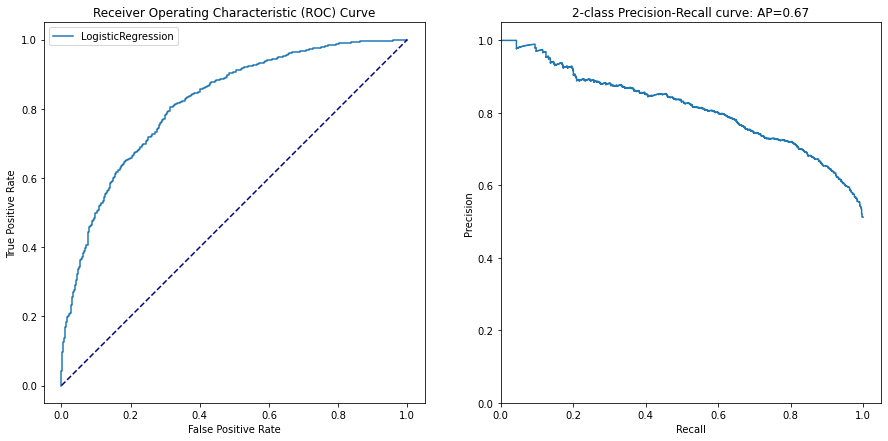

In [43]:
ML1.plot_roc_curve()
ML1.plot_pr_curve()

## Random Forest Classifier

In [44]:
parameters = {"n_estimators": np.arange(10, 100, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)
}
rando(RandomForestClassifier(random_state = 42), parameters)

Best parameters using accuracy score:
{'n_estimators': 60, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_depth': 5}
Best parameters usin ROC accuracy score:
{'n_estimators': 60, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_depth': None}


In [45]:
ML2 = MasterL(RandomForestClassifier, n_estimators = 60,min_samples_split=18, n_jobs = -1, min_samples_leaf=11,random_state = 42, max_depth=None,class_weight = 'balanced_subsample', 
             )

In [75]:
# Get your performance metrics
ML2.get_score()

RandomForestClassifier metrics:

 Accuracy Score: 71.91%
 Confusion matrix: 
 [[714 269]
 [286 707]]
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72       983
           1       0.72      0.71      0.72       993

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976

 ROC Score: 0.80%


In [47]:
rf_y_preds = ML2.predict(X_test)
rf_metrics = evaluate_preds(y_test, rf_y_preds)

Acc: 71.91%
Precision: 0.72
Recall: 0.71
F1 score: 0.72


### Plot to Validate Results

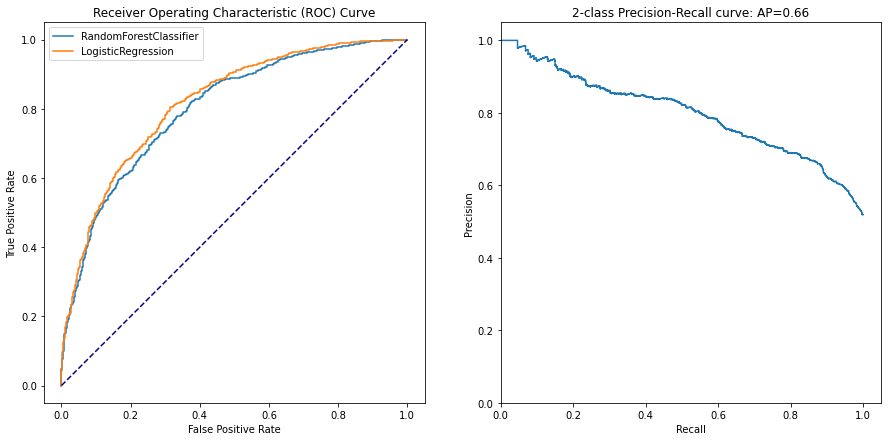

In [83]:
ML2.plot_roc_curve(models = [ML1])
ML2.plot_pr_curve()

In [48]:
features = ML2.clf.feature_importances_

In [57]:
#Creating a DataFrame that shows the Column name and there Importance to the RandomForest Model
Features_score = pd.DataFrame(np.array([cols, features]).T, columns = ["VarName", "Importance"]).sort_values(by=["Importance"], ascending=False)

Features_score.head()

,VarName,Importance
21,redTotalGold,0.134393
13,blueGoldPerMin,0.126775
8,blueTotalGold,0.109005
26,redGoldPerMin,0.0950296
9,blueTotalExperience,0.0904514


## Ensemble method clasifier (Logistic Regression + Random Forest)

In [50]:
# Generate ensemble
ML3 = MasterL(VotingClassifier, 
              estimators=[ ('lr', ML1.clf), ("rf", ML2.clf)], voting='soft', n_jobs = -1
             )
 
# Get your performance metrics
ML3.get_score()

VotingClassifier metrics:

 Accuracy Score: 72.77%
 Confusion matrix: 
 [[712 271]
 [267 726]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.73       983
           1       0.73      0.73      0.73       993

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976

 ROC Score: 0.81%


In [74]:
vc_y_preds = ML3.predict(X_test)
vc_metrics = evaluate_preds(y_test, vc_y_preds)

Acc: 72.77%
Precision: 0.73
Recall: 0.73
F1 score: 0.73


### Plot to Validate Results

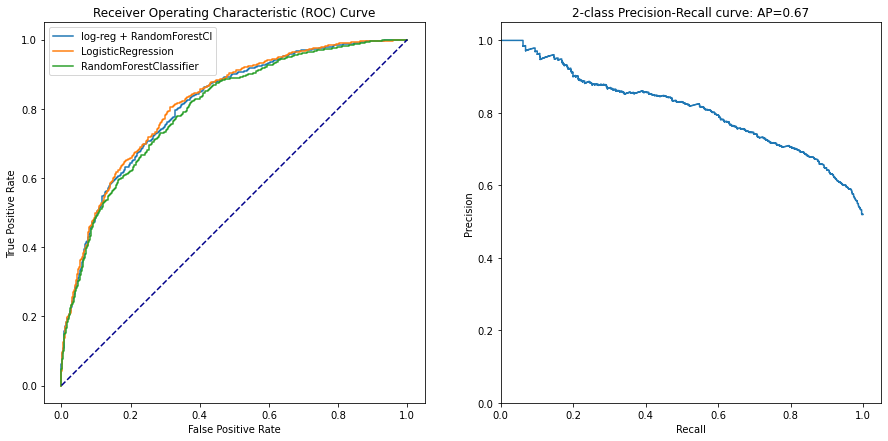

In [52]:
ML3.methodname = "log-reg + RandomForestCl"
ML3.plot_roc_curve(models = [ML1, ML2])
ML3.plot_pr_curve()

## Multi-layer Perceptron classifier(MLP)

In [32]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [33]:
# Setup random seed
np.random.seed(42)

#Setup RandomSearch
ml_rf = RandomizedSearchCV(MLPClassifier(), 
                           param_distributions=parameter_space,
                           cv=5,
                           n_iter=10,
                           verbose=True)
ml_rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.1min finished


RandomizedSearchCV(cv=5, estimator=MLPClassifier(),
                   param_distributions={'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(50, 50, 50),
                                                               (50, 100, 50),
                                                               (100,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['sgd', 'adam']},
                   verbose=True)

In [34]:
# Showing the best Parameters
ml_rf.best_params_

{'solver': 'sgd',
 'learning_rate': 'constant',
 'hidden_layer_sizes': (100,),
 'alpha': 0.0001}

In [36]:
# Multy Layer Perceptron
ML4 = MasterL(MLPClassifier, 
              activation = 'logistic',
              solver='sgd',
              alpha=.0001,
              hidden_layer_sizes=100, 
              random_state = 42, 
              max_iter= 1000 )
# Get your performance metrics 
ML4.get_score()

MLPClassifier metrics:

 Accuracy Score: 73.28%
 Confusion matrix: 
 [[721 262]
 [266 727]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       983
           1       0.74      0.73      0.73       993

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976

 ROC Score: 0.82%


In [38]:
ml_y_preds = ML4.predict(X_test)
ml_metrics = evaluate_preds(y_test, ml_y_preds)

Acc: 73.28%
Precision: 0.74
Recall: 0.73
F1 score: 0.73


### Plot to Validate Results

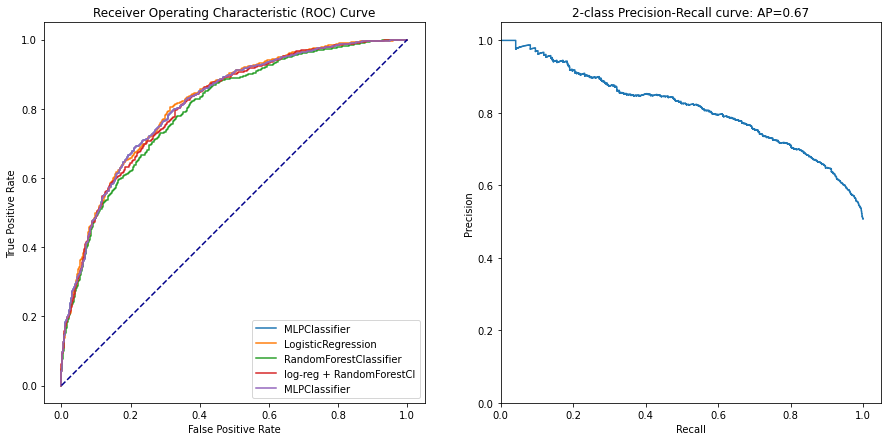

In [53]:
ML4.plot_roc_curve(models = [ML1, ML2, ML3,ML4])
ML4.plot_pr_curve()

In [54]:
rf_y_preds = ML3.predict(X_test)

In [55]:
rf_metrics = evaluate_preds(y_test, rf_y_preds)

Acc: 72.77%
Precision: 0.73
Recall: 0.73
F1 score: 0.73


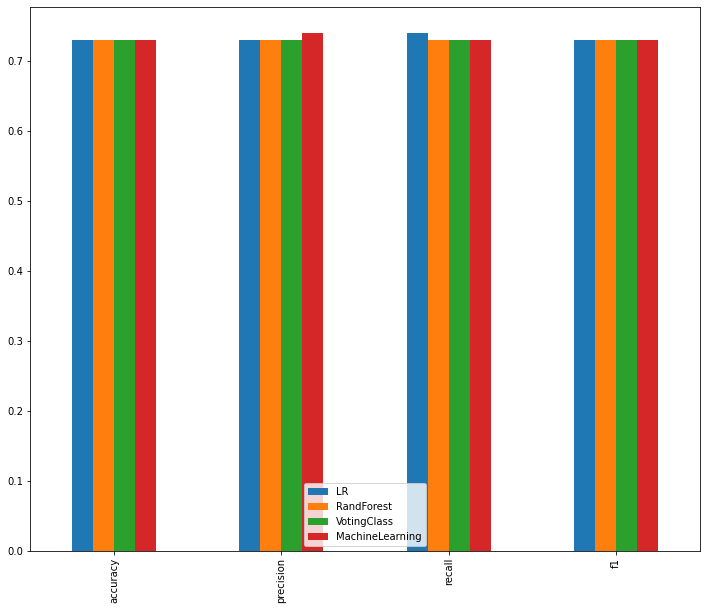

In [56]:
# Comparing each models Metrics Visually
compare_metrics = pd.DataFrame({"LR": lr_metrics,
                                "RandForest": rf_metrics,
                                "VotingClass":vc_metrics,
                                "MachineLearning": ml_metrics})

compare_metrics.plot.bar(figsize=(12, 10));

## We see that all models performed the same for the most part.  In order to improve the models further more data would be needed
  * to elaborate from https://www.leagueofgraphs.com/rankings/game-durations which tracks league of legends stats,
    the average game is about 30 minutes long across all different ranks.  Ideally I would speculate that our models would be much more accurate by having data from the first 15 minutes of games as opposed to 10.  This is mostly due to the increasing importance of objectives(blueDragonsCaptures), as well as the additional information to TotalGold per side.

## The Features Most correlated with Blue Side winning

In [60]:
# Getting the correlations with blueWinning from each feature in the dataframe
blue_corr=[]
for x in df.drop('blueWins',axis=1).columns:
    blue_corr.append(df['blueWins'].corr(df[x]))

In [61]:
blue_corr

[0.0009851278627279387,
 8.69510920139173e-05,
 0.04424680357157903,
 0.20176926438571072,
 0.3373576105342438,
 0.2766849645392132,
 0.21376769276290764,
 0.09238472474731753,
 0.4172125582921805,
 0.39614070565143955,
 0.22490947260651542,
 0.13144491466164815,
 0.2249094726065156,
 0.41721255829218035,
 -0.023671238287740027,
 -0.05540030842294104,
 -0.20176926438571072,
 -0.33929674108758545,
 -0.2710469185309073,
 -0.20951590157901545,
 -0.09717188056275666,
 -0.41139624735321484,
 -0.38758756472619005,
 -0.2121714644521725,
 -0.11099354457957147,
 -0.21217146445217233,
 -0.411396247353215]

In [63]:
# Creating a Dictionary of the columns and their respective correlation with blueWinning
feature_dict = dict(zip(df.drop('blueWins',axis=1).columns, blue_corr))
feature_dict

{'gameId': 0.0009851278627279387,
 'blueWardsPlaced': 8.69510920139173e-05,
 'blueWardsDestroyed': 0.04424680357157903,
 'blueFirstBlood': 0.20176926438571072,
 'blueKills': 0.3373576105342438,
 'blueAssists': 0.2766849645392132,
 'blueDragons': 0.21376769276290764,
 'blueHeralds': 0.09238472474731753,
 'blueTotalGold': 0.4172125582921805,
 'blueTotalExperience': 0.39614070565143955,
 'blueTotalMinionsKilled': 0.22490947260651542,
 'blueTotalJungleMinionsKilled': 0.13144491466164815,
 'blueCSPerMin': 0.2249094726065156,
 'blueGoldPerMin': 0.41721255829218035,
 'redWardsPlaced': -0.023671238287740027,
 'redWardsDestroyed': -0.05540030842294104,
 'redFirstBlood': -0.20176926438571072,
 'redKills': -0.33929674108758545,
 'redAssists': -0.2710469185309073,
 'redDragons': -0.20951590157901545,
 'redHeralds': -0.09717188056275666,
 'redTotalGold': -0.41139624735321484,
 'redTotalExperience': -0.38758756472619005,
 'redTotalMinionsKilled': -0.2121714644521725,
 'redTotalJungleMinionsKilled': 

<AxesSubplot:title={'center':'Feature Importance'}>

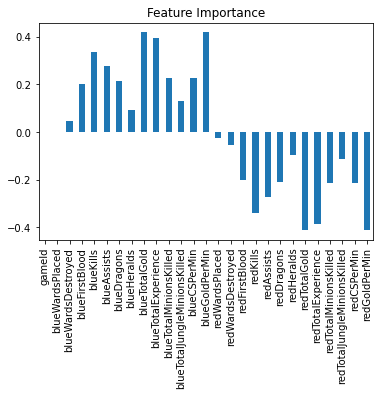

In [64]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False)

# From the above we see the Three most highly correlated features with blue side winning are
 * blueTotalGold
 * blueTotalExperience
 * blueGoldPerMin


# Now to look at Feature Importance for our Random Forest Model

In [65]:
Features_score.()

,VarName,Importance
21,redTotalGold,0.134393
13,blueGoldPerMin,0.126775
8,blueTotalGold,0.109005
26,redGoldPerMin,0.0950296
9,blueTotalExperience,0.0904514


In [70]:
Features_score.set_index('VarName', inplace=True)

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='VarName'>

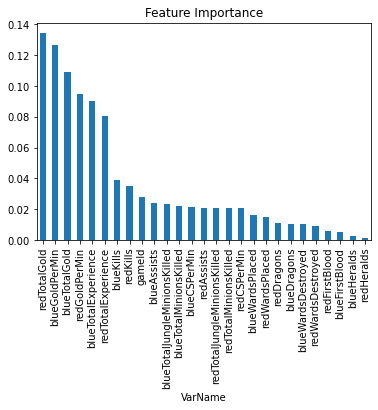

In [71]:
Features_score.plot.bar(title="Feature Importance", legend=False)

# Here we see the model took higher priority to the opposing teams TotalGold as a predictor as to whether or not blue will win

### Very interesting, if we are to continue to improve on our Random Forest Model it would be worth trying to engineer features for Red Side in an attempt to see if those improved model performance